# 1. Set Up Notebook and Load Data 

In [1]:
import matplotlib.pyplot as plt
from pathlib import Path
import numpy as np
import pandas as pd
import fnmatch
import pickle
import ipywidgets as widgets
from IPython.display import display
import sys
import os
import math
from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.model_selection import train_test_split
import tensorflow as tf 
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))
# Check for TensorFlow GPU access
print(f"TensorFlow has access to the following devices:\n{tf.config.list_physical_devices()}")
# See TensorFlow version
print(f"TensorFlow version: {tf.__version__}")
import math
from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from tensorflow.keras import layers, models, losses
from tensorflow.keras.layers import Conv2D, MaxPooling2D, UpSampling2D, Reshape, Input, Flatten, Dense, Conv2DTranspose, LeakyReLU, BatchNormalization,  LeakyReLU,  Activation, LSTM, TimeDistributed, RepeatVector, Lambda, Conv3D, Conv3DTranspose
from tensorflow.keras.callbacks import EarlyStopping, LearningRateScheduler, ReduceLROnPlateau
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.optimizers.legacy import Adam
from keras.activations import elu
from tensorflow.keras.initializers import HeUniform, GlorotUniform, HeNormal, LecunNormal
from keras.regularizers import l2, l1, Regularizer
from tensorflow.keras import regularizers

# CUSTOM Imports
def list_folders_fun(path):
    """
    DESCRIPTION: List folders in a given directory.
    INPUT: Directory path
    OUTPUT: Folder names in a given directory
    """
    folder_list = [f.name for f in Path(path).iterdir() if f.is_dir()]
    return folder_list

# Specify global path
global_path = '/Users/steven/Library/Mobile Documents/com~apple~CloudDocs/0-CfA/4-Data/Datasets'
global_folders = list_folders_fun(global_path)

# Select dataset
set_widget = widgets.Dropdown(options=global_folders[:],value=global_folders[0],description='Set :',disabled=False); set_widget

Num GPUs Available:  1
TensorFlow has access to the following devices:
[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'), PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
TensorFlow version: 2.12.0


Dropdown(description='Set :', options=('Full', 'All', 'Full_extra', 'New', 'Bona'), value='Full')

In [5]:
# Set ID
set_id = set_widget.value
# Select Input
files = os.listdir(f'{global_path}/{set_id}/')
input_files = [f for f in files if fnmatch.fnmatch(f, 'hist3D*minmax*')]
# input_files = [f for f in files if fnmatch.fnmatch(f, 'hist3D*24*none*')]
input_widget = widgets.Dropdown(options=input_files[:],value=input_files[0],description='TSNE File :',disabled=False); input_widget

IndexError: list index out of range

In [17]:
# Load features
input_file = input_widget.value
with open(f'{global_path}/{set_id}/{input_file}', 'rb') as f:
    hist_dict = pickle.load(f)
ids = list(hist_dict.keys())
histograms = hist_dict.values()
features = np.array([np.array(h) for h in histograms])
# Load properties
df_properties_input = pd.read_csv(f'{global_path}/{set_id}/properties-input-Full.csv')
df_properties_input = df_properties_input[df_properties_input['obsreg_id'].isin(list(ids))]
df_properties = df_properties_input.drop_duplicates('obsreg_id', keep='first').reset_index(drop=True)
# Data
df_label = df_properties.copy()
ID = df_label['obsreg_id'].values
X = features
x = tf.expand_dims(X, 4)
rs = 505
splits = 0.1
X_train, X_test, ID_train, ID_test = train_test_split(X, ID, test_size=splits, random_state=rs)
x_train = tf.expand_dims(X_train, 4)
x_test = tf.expand_dims(X_test, 4)

# Print Summary
print ('Training Set', X_train.shape)
print ('Test Set', X_test.shape)
print("Number of Features: ", len(features))
print("Number of Property Sets: ", len(df_properties))

df_label.head()

Training Set (85925, 24, 16, 16)
Test Set (9548, 24, 16, 16)
Number of Features:  95473
Number of Property Sets:  95473


,name,obsreg_id,hard_hm,hard_hs,hard_ms,var_prob_b,var_prob_h,var_prob_m,var_prob_s,var_index_b
0,2CXO J173522.0-260053,10037_123,0.354778,0.782011,0.540912,0.077612,0.092974,0.756124,NaN,0.0
1,2CXO J173403.7-260619,10037_30,0.564647,0.999375,0.999375,0.475838,0.436236,0.488032,NaN,0.0
2,2CXO J173412.7-260548,10037_40,0.033729,0.343535,0.312305,0.119011,0.438140,0.236688,0.551795,0.0
3,2CXO J173416.8-260131,10037_79,0.352280,0.801999,0.610868,0.135159,0.314770,0.834953,NaN,0.0
4,2CXO J173426.3-255911,10037_81,0.548407,0.999375,0.999375,0.299827,0.675399,0.370636,NaN,0.0


# 3. Automodel Model

In [18]:
# Custom callback to update the learning rate
class StepDecayScheduler(tf.keras.callbacks.Callback):
    def __init__(self, initial_lr, decay_steps, decay_rate):
        super(StepDecayScheduler, self).__init__()
        self.initial_lr = initial_lr
        self.decay_steps = decay_steps
        self.decay_rate = decay_rate

    def on_epoch_begin(self, epoch, logs=None):
        updated_lr = self.initial_lr * (self.decay_rate ** (epoch // self.decay_steps))
        tf.keras.backend.set_value(self.model.optimizer.lr, updated_lr)
        print(f"Learning rate for epoch {epoch+1}: {updated_lr}")

import keras.backend as K
from keras.layers import Masking
from keras.losses import mse

def masked_mse(y_true, y_pred, mask_value=0):
    mask = K.cast(K.not_equal(y_true, mask_value), K.floatx())
    num_masked = K.sum(mask)
    mse = K.square(mask * (y_true - y_pred))
    return K.sum(mse) / num_masked

# def masked_mse(y_true, y_pred):
#     mask = K.cast(K.not_equal(y_true, 0), dtype=K.floatx())
#     masked_squared_error = K.square(mask * (y_true - y_pred))
#     masked_mse = K.sum(masked_squared_error, axis=-1) / K.sum(mask, axis=-1)
#     return masked_MSE
# masking_layer = Masking(mask_value=0.)

from keras.utils import custom_object_scope


In [11]:
input_shape = (24, 16,16)
in1 = 24
in2 = 16
in3 = 16
activation = LeakyReLU(alpha=0.1) # 'relu'# 'selu' #LeakyReLU(alpha=0.1) #'relu' #LeakyReLU(alpha=0.1) #'relu' #LeakyReLU(alpha=0.2) # 'selu' # LeakyReLU(alpha=0.2)
kernel_init = 'he_normal'  # 'glorot_uniform' #HeUniform(seed=505) # 'he_normal' #'glorot_uniform' #HeNormal(seed=505) #glorot_uniform' #'he_normal' #'glorot_uniform'
encoder_dims = [1536,384,96]   
encoder_dims = [1536,1536,384,384,96]   
encoder_dims = [3072,768,128]  
encoder_dims = [1536,384,384,96,24,24]  
encoder_dims = [768,768,192,192,48]
encoder_dims = [1536*2,1536,384*2,384,192,96,48] 
encoder_dims = [1536,384,96,24] 
encoder_dims = [1536,384,96] 
encoder_dims = [1536,768,128,32] 
encoder_dims = [1536,384,96,32] 
decoder_dims = encoder_dims[::-1]
bottleneck = 16
epochs = 250
batch = 1024
lr = 0.001
botreg = 0.1
# Define encoder
model = Sequential()
model.add(Flatten(input_shape=input_shape))
for dim in encoder_dims:
    model.add(Dense(dim, activation=activation, kernel_initializer = kernel_init))
    model.add(BatchNormalization(momentum=0.9))
# Define bottleneck
model.add(Dense(bottleneck, activation=activation, kernel_initializer = kernel_init, kernel_regularizer=regularizers.l2(botreg), name='bottleneck'))
# Define decoder
for dim in decoder_dims:
    model.add(Dense(dim, activation=activation, kernel_initializer = kernel_init))
    model.add(BatchNormalization(momentum=0.9))
    
model.add(Dense(in1*in2*in3,activation='sigmoid')) # CHANGE FOR MIN MAX 
model.add(Reshape((in1,in2,in3)))

# masked_output = tf.multiply(model.output, tf.cast(tf.not_equal(model.input, 0), tf.float32))
# model = tf.keras.Model(inputs=model.input, outputs=masked_output)

model.summary()
# Training Set Up
name = input('Name: ')
print(name)

early_stopping = EarlyStopping(monitor='val_loss', patience=25, verbose=1, restore_best_weights=True)
loss_function = masked_mse
reduce_lr_callback = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=10)
optimizer = Adam(learning_rate = lr)
model.compile(optimizer=optimizer, loss=loss_function)

# Define a callback function to display the learning rate for each epoch
bottle_index = model.layers.index(model.get_layer(name='bottleneck'))
print('Depth: ', bottle_index)
history = model.fit(X_train, X_train, epochs=epochs,batch_size=batch,shuffle=True,validation_split=0.2,callbacks=[reduce_lr_callback , early_stopping]) # 128 or 256, 512, 1024, 2048, 4096
encoder_model = Model(inputs=model.input, outputs=model.layers[bottle_index].output)
# Saving
model.save(f'{global_path}/{set_id}/XAE-AUTOENCODER-3D-FC-fc{encoder_dims}-neck{bottleneck}-lr{lr}-b{batch}-reg{botreg}-{name}.h5')
encoder_model.save(f'{global_path}/{set_id}/XAE-ENCODER-3D-FC-fc{encoder_dims}-neck{bottleneck}-lr{lr}-b{batch}-reg{botreg}-{name}.h5')
with open(f'{global_path}/{set_id}/XAE-HISTORY-3D-FC-fc{encoder_dims}-neck{bottleneck}-lr{lr}-b{batch}-reg{botreg}-{name}.pickle', 'wb') as file:
    pickle.dump(history.history, file)



Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_1 (Flatten)         (None, 6144)              0         
                                                                 
 dense_9 (Dense)             (None, 1536)              9438720   
                                                                 
 batch_normalization_8 (Batc  (None, 1536)             6144      
 hNormalization)                                                 
                                                                 
 dense_10 (Dense)            (None, 384)               590208    
                                                                 
 batch_normalization_9 (Batc  (None, 384)              1536      
 hNormalization)                                                 
                                                                 
 dense_11 (Dense)            (None, 96)               

KeyboardInterrupt: Interrupted by user

In [19]:
# Select saved model
files = os.listdir(f'{global_path}/{set_id}/')
ac_files = [f for f in files if fnmatch.fnmatch(f, '*-AUTOENCODER*3D*FC*fc[*xae24*h5')]
encode_files = [f for f in files if fnmatch.fnmatch(f, '*-ENCODER*3D*FC*fc[*xae24*h5')]
hist_files = [f for f in files if fnmatch.fnmatch(f, '*-HISTORY*3D*FC*fc[*xae24*pickle')]
ac_widget = widgets.Dropdown(options=ac_files[:],value=ac_files[-1],description='Autoencoder :',disabled=False,style = {'description_width': 'initial'}); ac_widget 
hist_widget = widgets.Dropdown(options=hist_files[:],value=hist_files[-1],description='History :',disabled=False,style = {'description_width': 'initial'}); hist_widget 
encode_widget = widgets.Dropdown(options=encode_files[:],value=encode_files[-1],description='Encoder :',disabled=False,style = {'description_width': 'initial'}); encode_widget 
layout = widgets.HBox([ac_widget, hist_widget, encode_widget])
display(layout)

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_2 (Flatten)         (None, 6144)              0         
                                                                 
 dense_28 (Dense)            (None, 1536)              9438720   
                                                                 
 batch_normalization_26 (Bat  (None, 1536)             6144      
 chNormalization)                                                
                                                                 
 dense_29 (Dense)            (None, 384)               590208    
                                                                 
 batch_normalization_27 (Bat  (None, 384)              1536      
 chNormalization)                                                
                                                                 
 dense_30 (Dense)            (None, 96)               

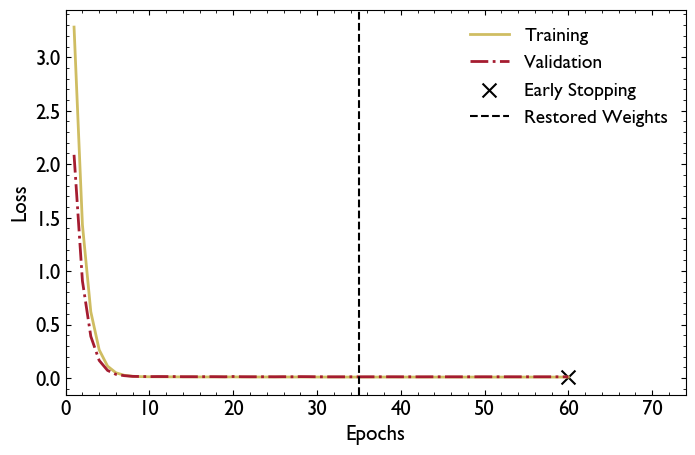

In [21]:
# Load the selected saved model 
ac = ac_widget.value
h = hist_widget.value
e = encode_widget.value

with custom_object_scope({'masked_mse': masked_mse}):
    model = tf.keras.models.load_model(f'{global_path}/{set_id}/{ac}')
with custom_object_scope({'masked_mse': masked_mse}):
    encoder_model = tf.keras.models.load_model(f'{global_path}/{set_id}/{e}')

# model = tf.keras.models.load_model(f'{global_path}/{set_id}/{ac}')
# encoder_model = tf.keras.models.load_model(f'{global_path}/{set_id}/{e}')
model.summary()
encoder_model.summary()
with open(f'{global_path}/{set_id}/{h}', 'rb') as file:
    summary = pickle.load(file)


imperial = '#003E74'
imperial2 = '#002147'
darkblue = '#003170'
harvard = '#A51C30'
silver = '#777777'
silver2 = '#C0C0C0'
gold = '#cfbd62'
#plot the training and validation accuracy and loss at each epoch
sizefont = 15
sizefont2 = 14
plt.rcParams.update({'font.size': sizefont})
plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.sans-serif'] = 'Gill Sans'
fig, ax1 = plt.subplots(1, 1, figsize=(8, 5))

loss = summary['loss']
val_loss = summary['val_loss']
epochs = range(1, len(loss) + 1)
ax1.plot(epochs, loss, c=gold, label='Training',linewidth=2)
ax1.plot(epochs, val_loss, c=harvard, linestyle = '-.',label='Validation',linewidth=2)
ax1.scatter(epochs[-1], val_loss[-1], marker = 'x', c='black',s=100, label='Early Stopping')
min_index = val_loss.index(min(val_loss))
last_index = val_loss.index(val_loss[-1])
print("restored", min_index)
print("early stopping", last_index)
line = plt.axvline(x=epochs[min_index], color='black',linestyle = '--',label = 'Restored Weights') #52 for stjohns6, 77 for stjohns 16 #61 for 0.001, 128
ax1.set_xlabel('Epochs')
ax1.set_xlim([0,74])
ax1.set_ylabel('Loss')

ax1.minorticks_on()
ax1.tick_params(which='both', direction='in', top=True, right=True)
plt.legend(loc='upper right', frameon=False, fontsize = sizefont2)
# plt.legend(loc='upper center', frameon=False, fontsize = sizefont2)
plt.show()

# from keras.utils import plot_model
# plot_model(model, show_shapes=True, show_layer_names=True, to_file='autoencoder.png')

# # Load the image and display it
# img = plt.imread('autoencoder.png')

In [22]:
test_loss = model.evaluate(X_test, X_test)
test_recon = model.predict(X_test)
compression_ratio = 6144/24

performance = compression_ratio/test_loss
# perf = compression_ratio/
# Print the test loss
print(f'Test loss: {test_loss:.4f}') 
print(f'Compression ratio: {compression_ratio}') 
print(f'Performance: {performance}') 

#0.0088 yuri
# print('Compression Ratio: ', compression_ratio)
# print(f'Metric:', )

reconstructions = model.predict(X)
embedding = encoder_model.predict(X)
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
embedding2 = scaler.fit_transform(embedding)

299/299 [==============================] - 1s 4ms/step
Test loss: 0.0115
Compression ratio: 256.0
Performance: 22356.39089106772
2984/2984 [==============================] - 5s 2ms/step


In [23]:
import random
from matplotlib.colors import LogNorm
# filtered_ids = [id for id in ids if id.split('_')[1] == '10'][10:20]
#####SELECTED ANOMALIES
flares_maybe = ['10542_331','10556_6687','10556_5752','10556_6687']
dips_maybe = ['13814_586','13813_218']
# DIPS ET AL
parmar = ['10783_10','10871_10','11059_10','9070_10'] # LMXB dips!
distefano = ['13814_567']
m101ulx = ['4736_81','6170_74','4733_229','4737_74','5300_95','5322_229','6152_81']
ieva = ['11272_13','13812_586','13812_218','9550_17','942_101','6152_79']
# FLARES ET AL 
lin = ['4062_31', '13454_56','20635_58'] 
xue = ['957_208', '3389_274','15211_38']
irwin = ['3926_13','7800_4','7799_16','8490_30']
glennie = ['12884_10']
jonker = ['803_90']
vasquez = ['2025_39','9546_17','9548_14','12264_54','15113_59']
vasquez = ['2025_39','9548_14','15113_59']
nandra = ['9875_166', '9456_274', '5849_62']
goulding =['8636_2', '8636_3'] # last one not listed 2012 2015
flares = ['4395_992','16444_1025','13637_1078','14368_489','14368_503','10822_185','10955_21','10996_5','2833_53','13610_112','15214_29','1042_24']
NEW = ['23022_122']
ran = random.randint(0, 95000)
r = ids[ran:ran+10]
items_to_find = NEW + xue + lin + distefano + parmar 
# items_to_find = r
# Using a list comprehension to find indices of items in the other list
indices = [ids.index(item) for item in items_to_find]

n = len(indices)
fig = plt.figure(figsize=(20, 6))
top = 40
k = 0 

# for i in indices:
#   k = k+1
#   # display original
#   ax = fig.add_subplot(2, n, k, projection='3d')
#   data_original = X[i]
#   x, y, z = data_original.nonzero()
#   h = np.ravel(data_original)
#   print(h)
#   ax.scatter(x, y, z, marker='o', s=50, c=h, edgecolors='none',cmap='plasma', norm = LogNorm())
#   ax.set_title("Original")
#   ax.set_xticks([])
#   ax.set_yticks([])
#   ax.set_zticks([])

#   # display reconstruction
#   ax = fig.add_subplot(3, n, k + n, projection='3d')
#   data_reconstructed = reconstructions[i]
#   x, y, z = data_reconstructed.nonzero()
#   h = data_reconstructed
#   print(h)
#   ax.scatter(x, y, z, marker='o', s=50, c=h, edgecolors='none',cmap='plasma', norm = LogNorm())
#   ax.set_title("Reconstruction")
#   ax.set_xticks([])
#   ax.set_yticks([])
#   ax.set_zticks([])

#   # display encoded results
#   ax = plt.subplot(3, n, k+n+n)
#   plt.imshow(embedding[i].reshape((4,6)).T,cmap='cividis')
#   plt.title(f'Latent')
#   ax.get_xaxis().set_visible(False)
#   ax.get_yaxis().set_visible(False)


<Figure size 2000x600 with 0 Axes>

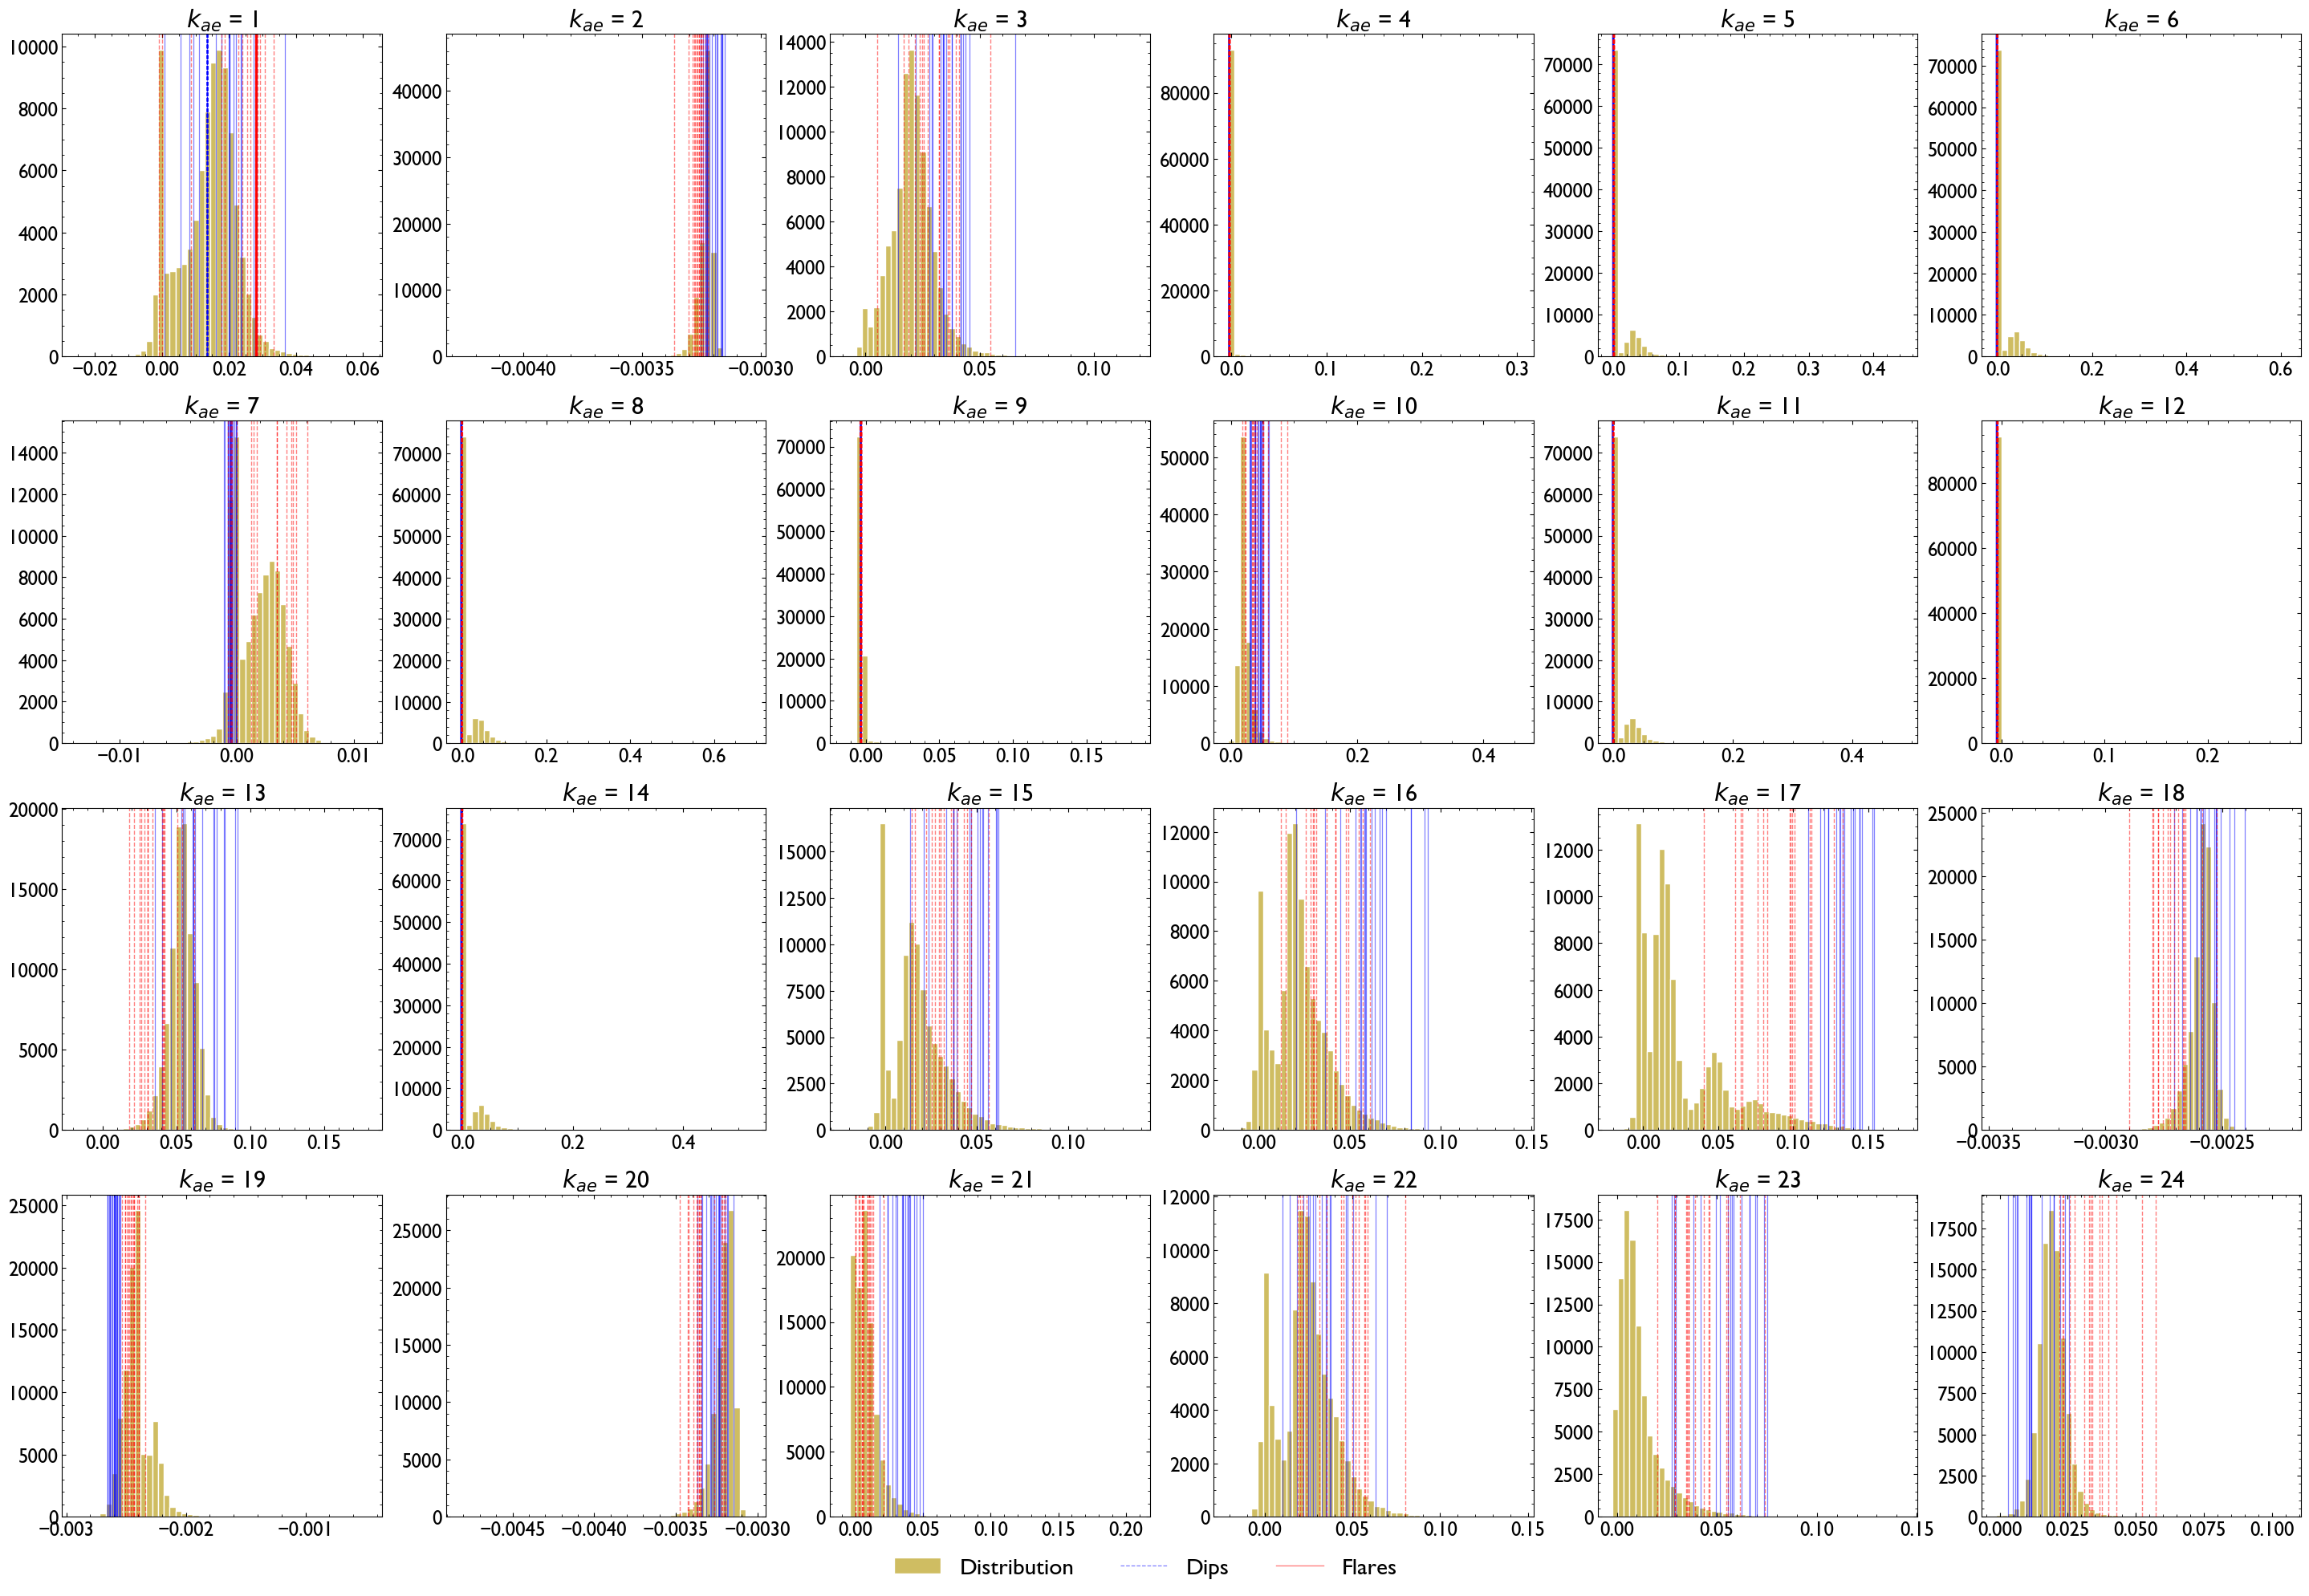

In [26]:
# Define the indices to plot separately
dips_to_find = parmar + m101ulx + ieva + distefano 
flares_to_find = jonker + glennie + lin + xue + vasquez + nandra + NEW 
flare_indices = [ids.index(item) for item in flares_to_find]
dip_indices = [ids.index(item) for item in dips_to_find]

# Create a 16x90 array from the embedding data
embedding_array = np.array(embedding).T

# Create a separate subplot for each element
sizefont = 18
sizefont2 = 21
plt.rcParams.update({'font.size': sizefont})
plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.sans-serif'] = 'Gill Sans'
fig, axs = plt.subplots(4,6, figsize=(36,24),constrained_layout = False)
alpha = 1
alpha2 = 0.5
edge = 'white'

# Plot a histogram for each element (column) in the array
for i in range(24):
    row = i // 6
    col = i % 6
    ax = axs[row, col]
    
    # Plot a histogram for the element
    ax.hist(embedding_array[i], bins=50,color=gold,alpha=alpha,edgecolor=edge,label = 'Distribution')
    # ax.set_title(f"Element {i+1}")
    
    # Plot a separate line for the selected indices
     # Plot a separate line for the selected indices  
    axs[0,0].axvline(x=embedding_array[0][dip_indices[0]], color='b',linestyle='--',linewidth=0.9,label = 'Dips',alpha=alpha2)
    axs[0,0].axvline(x=embedding_array[0][flare_indices[0]], color='r',linestyle='-',linewidth=1,label = 'Flares',alpha=alpha2)
    
    for j in dip_indices:
        ax.axvline(x=embedding_array[i][j], color='b',linestyle='-',linewidth=0.9,alpha=alpha2)
    for j in flare_indices:
        ax.axvline(x=embedding_array[i][j], color='r',linestyle='--',linewidth=1,alpha=alpha2)
    ax.minorticks_on()
    ax.tick_params(which='both', direction='in', top=True, right=True)
    ax.set_title(r'$k_{ae}$ = ' + f'{i+1}')
    # ax.set_ylabel('Counts')


legend_labels = ['Distribution', 'Dips','Flares']
fig.legend(legend_labels, loc='lower center', ncol=3,bbox_to_anchor=(0.5, 0.067),frameon= False,fontsize=sizefont2 )

plt.show()

In [29]:
import pandas as pd
import numpy as np
from scipy.stats import spearmanr
from sklearn import preprocessing

emb_array = np.array(embedding)
prop_array = df_label[['hard_hm', 'hard_hs', 'hard_ms', 'var_prob_b', 'var_prob_h', 'var_prob_m', 'var_prob_s', 'var_index_b']].values

# Assuming you have two arrays: latent_features (shape: (90000, 5)) and summary_properties (shape: (90000, 8))
latent_features = emb_array
summary_properties = prop_array

# Convert the arrays into a pandas DataFrame
latent_df = pd.DataFrame(latent_features, columns=['{}'.format(i+1) for i in range(latent_features.shape[1])])
summary_df = pd.DataFrame(summary_properties, columns=['hard_hm', 'hard_hs', 'hard_ms', 'var_prob_b', 'var_prob_h', 'var_prob_m', 'var_prob_s', 'var_index_b'])

# Concatenate the two DataFrames
df = pd.concat([latent_df, summary_df], axis=1)

# Normalize the data
scaler = preprocessing.MinMaxScaler()
df_normalized = pd.DataFrame(scaler.fit_transform(df), columns=df.columns)

# Compute the correlation matrix
correlation_matrix = df_normalized.corr()
correlation_matrix2 = df_normalized.corr(method='spearman')
correlation_matrix3 = df_normalized.corr(method='kendall')

# Select only the columns related to the summary properties
summary_correlation_df = correlation_matrix[summary_df.columns]
summary_correlation_df2 = correlation_matrix2[summary_df.columns]
summary_correlation_df3 = correlation_matrix3[summary_df.columns]

# Display the correlation table for summary properties
print(summary_correlation_df.head(24))
summary_correlation_df3.head(24)



     hard_hm   hard_hs   hard_ms  var_prob_b  var_prob_h  var_prob_m   
1   0.037526  0.067227  0.076538    0.068226    0.019933    0.005365  \
2   0.033403  0.027387  0.012236   -0.068299   -0.094390   -0.105936   
3  -0.142221 -0.072311  0.022026    0.105291    0.037350    0.027842   
4   0.024105  0.014548  0.000933   -0.003538    0.007522    0.014387   
5   0.057886  0.038806  0.009892   -0.002535    0.026244    0.035863   
6   0.056944  0.037790  0.009169   -0.007566    0.022601    0.031811   
7  -0.030143 -0.002430  0.018258    0.029005    0.037891    0.062831   
8   0.054754  0.035692  0.007772   -0.007361    0.022091    0.031464   
9   0.034027  0.021193  0.002922   -0.021532   -0.000307    0.006740   
10  0.038318  0.055456  0.055280    0.185081    0.138407    0.125936   
11  0.057815  0.038766  0.010022   -0.006947    0.023287    0.032275   
12  0.022353  0.013008 -0.000403   -0.001006    0.010053    0.017107   
13 -0.039622 -0.043644 -0.019680   -0.127199   -0.097162   -0.07

,hard_hm,hard_hs,hard_ms,var_prob_b,var_prob_h,var_prob_m,var_prob_s,var_index_b
1,0.019702,0.040314,0.045901,-0.036802,-0.037753,-0.037514,-0.052627,0.073191
2,0.046796,0.032177,0.008508,-0.134605,-0.111122,-0.109929,-0.107826,-0.033066
3,-0.110802,-0.051003,0.024236,-0.037736,-0.036866,-0.042009,-0.065062,0.084431
4,0.047229,0.025054,-0.005858,0.144957,0.120213,0.130603,0.141196,-0.010387
5,0.058414,0.034704,0.001379,0.122308,0.101845,0.117709,0.148365,-0.064279
6,0.051972,0.034316,0.010391,0.088707,0.075075,0.091097,0.127015,-0.097524
7,-0.024828,-0.002716,0.015111,0.013297,0.016896,0.031610,0.045424,0.011923
8,0.046801,0.024571,-0.001615,0.094319,0.080803,0.095583,0.127614,-0.091119
9,0.085651,0.064102,0.026079,0.070344,0.060639,0.077113,0.120210,-0.099190
10,0.019675,0.034199,0.031615,0.046538,0.023384,0.023755,-0.004143,0.136581


In [42]:
mask = np.where(X != 0, 1, 1)
# Apply the mask to reconstructions and X
masked_reconstructions = np.multiply(reconstructions, mask)
masked_X = np.multiply(X, mask)
recerr = tf.keras.losses.mean_squared_error(masked_reconstructions, masked_X)
rec_err = np.mean(recerr,axis=(1, 2))



In [47]:
rec_err = np.mean(recerr,axis=(1, 2))
print(len(recerr))
print(rec_err.shape)

95473
(95473,)


In [35]:
print(rec_err.shape)

()


IndexError: list index out of range

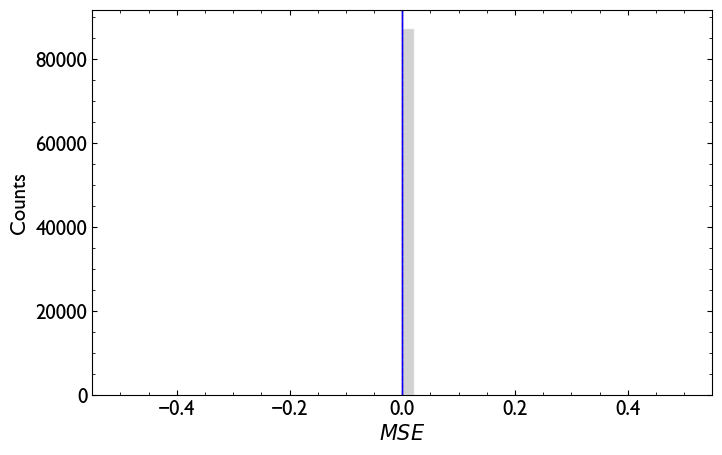

In [48]:
imperial = '#003E74'
imperial2 = '#002147'
darkblue = '#003170'
harvard = '#A51C30'
silver = '#777777'
silver2 = '#C0C0C0'
gold = '#cfbd62'
sizefont = 15
sizefont2 = 14
plt.rcParams.update({'font.size': sizefont})
plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.sans-serif'] = 'Gill Sans'
fig, ax = plt.subplots(1, 1, figsize=(8, 5))
alpha = 0.7
alpha2 =0.7
edge = 'white'

perc = np.percentile(rec_err,10)
rec_err = [x for x in rec_err if x <= perc]


ax.hist(rec_err, bins=50,color=silver2,alpha=alpha,edgecolor=edge,label = 'Distribution')
ax.minorticks_on()
ax.set_xlabel(r'$MSE$')
ax.set_ylabel('Counts')
ax.tick_params(which='both', direction='in', top=True, right=True)

dips_to_find = parmar + m101ulx + ieva + distefano 
flares_to_find = jonker + glennie + lin + xue + vasquez + nandra + NEW 
flare_indices = [ids.index(item) for item in flares_to_find]
dip_indices = [ids.index(item) for item in dips_to_find]

ax.axvline(x=rec_err[dip_indices[0]], color='blue',linestyle='-',linewidth=0.9,label = 'Dips',alpha=alpha2)
ax.axvline(x=rec_err[flare_indices[0]], color='red',linestyle='--',linewidth=1,label = 'Flares',alpha=alpha2)

for j in dip_indices:
    ax.axvline(x=rec_err[j], color='blue',linestyle='-',linewidth=0.9,alpha=alpha2)
for j in flare_indices:
    ax.axvline(x=rec_err[j], color='red',linestyle='--',linewidth=1,alpha=alpha2)
ax.legend(loc='upper right',frameon= False,fontsize=sizefont2)